# Make Spice Anomaly Maps

Serves issue #6
Use the local linearization of the equation of state and the mean temperature and salinity to estimate spice anomalies.

Will require some interpolation routine that takes from depth to density space and back.



In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import xarray as xr 

import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm
import glidertools as gt

from cmocean import cm as cmo

import gsw

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

In [4]:
ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [5]:
ds_659['potdens'] = gt.physics.potential_density(ds_659.salinity, 
                                                 ds_659.temperature, 
                                   ds_659.pressure, ds_659.latitude, 
                                   ds_659.longitude)

ds_660['potdens'] = gt.physics.potential_density(ds_660.salinity, 
                                                 ds_660.temperature, 
                                   ds_660.pressure, ds_660.latitude, 
                                   ds_660.longitude)

In [6]:
days = ds_659.time - np.datetime64('2019-01-01')
ds_659['round_days'] = (days / np.timedelta64(1, 'D')).round()

days = ds_660.time - np.datetime64('2019-01-01')
ds_660['round_days'] = (days / np.timedelta64(1, 'D')).round()

### Vertical regridding

In [7]:
profile = ds_659.where(ds_659.dives==301, drop=True)

In [8]:
profile_temp_grid = gt.grid_data(profile.dives, 
                                 profile.pressure, 
                                 profile.temperature)

Mean bin size = 1.02
Mean depth binned (50 m) vertical sampling frequency = 0.92


In [9]:
profile_temp_grid2m = gt.grid_data(profile.dives, 
                                 profile.pressure, 
                                 profile.temperature, 
                                 bins=np.linspace(0,1000,500))

Mean bin size = 2.00
Mean depth binned (50 m) vertical sampling frequency = 0.92


In [10]:
profile_temp_grid1m = gt.grid_data(profile.dives, 
                                 profile.pressure, 
                                 profile.temperature, 
                                 bins=np.linspace(0,1000,1000))

Mean bin size = 1.00
Mean depth binned (50 m) vertical sampling frequency = 0.92


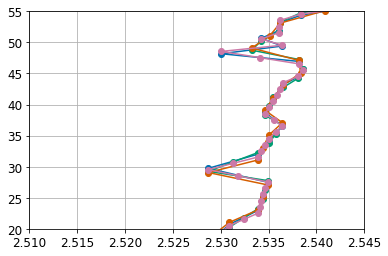

In [11]:
plt.plot(profile.temperature.values[0:50], profile.pressure.values[0:50],
        marker='o')
plt.plot(profile_temp_grid, profile_temp_grid.pressure,
        marker='o')
plt.plot(profile_temp_grid2m, profile_temp_grid2m.pressure,
        marker='o')
plt.plot(profile_temp_grid1m, profile_temp_grid1m.pressure,
        marker='o')
plt.ylim([20,55])
plt.xlim([2.51, 2.545])
plt.grid()

Currently glider tools does vertical gridding by using binning. This is a slightly rudimentary technique, and technically something more fancy can be implemented. However, this sort of works for our purposes. 

Since the data is being converted to a pandas series, it might not be very tricky to have a general implementation that can access all the interpolation methods available to pandas (which is all of scipy). 

## Consider Straight Section

Text(0.5, 1.0, 'Glider Tracks')

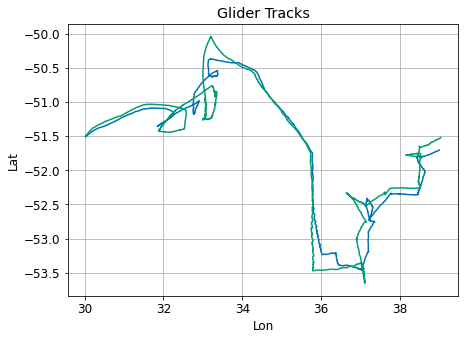

In [67]:
plt.figure(figsize = (7,5))

#plt.subplot(121)
plt.plot(ds_659.longitude, ds_659.latitude, label='659')

#plt.subplot(122)
plt.plot(ds_660.longitude, ds_660.latitude, label='660')


plt.grid()
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title('Glider Tracks')


Make some bokeh plots to help figure out where the "straight" line sections are. 

In [19]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

In [20]:
output_notebook()

Loading BokehJS ...

In [32]:
from bokeh.plotting import ColumnDataSource

In [38]:
lat = ds_659.latitude.groupby(ds_659.dives).mean()
lon = ds_659.longitude.groupby(ds_659.dives).mean()
dives = lon.dives

source = ColumnDataSource(data=dict(
    x=lon.values,
    y=lat.values,
    dives=dives.values,
))

TOOLTIPS = [
    ("dive", "@dives"),
    ("(x,y)", "($x, $y)"),
]

p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS,
           title="659 Track")

# add a circle renderer with x and y coordinates, size, color, and alpha
p.circle('x', 'y', source=source)

show(p)

# section 1 = 200-241
# section 2 = 241.5 - 288.5

In [39]:
section_1_659 = [200, 241]
section_2_659 = [241.5, 288.5]

In [37]:
lat = ds_660.latitude.groupby(ds_660.dives).mean()
lon = ds_660.longitude.groupby(ds_660.dives).mean()
dives = lon.dives

source = ColumnDataSource(data=dict(
    x=lon.values,
    y=lat.values,
    dives=dives.values,
))

TOOLTIPS = [
    ("dive", "@dives"),
    ("(x,y)", "($x, $y)"),
]

p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS,
           title="660 Track")

# add a circle renderer with x and y coordinates, size, color, and alpha
p.circle('x', 'y', source=source)

show(p)

# section 1 - 240-286
# section 2 - 286.5 - 335.5

In [77]:
section_1_660 = [240, 286]
section_1_660_long = [223, 286]

section_2_660 = [286.5, 335.5]

Sections 1 scatter plots

In [72]:
def plot_sections_scatter(ds, varx, vary, varz, sec,cmap, size, ax):
    selection = np.logical_and(ds.dives<sec[1], ds.dives>sec[0])
    gt.plot.scatter(ds[varx].where(selection, drop=True),
        ds[vary].where(selection, drop=True),
        ds[varz].where(selection, drop=True),
        cmap=cmap, robust=True, s=size, ax=ax)

In [83]:
def plot_sections_contourf(ds, varx, vary, varz, sec,cmap, ax):
    selection = np.logical_and(ds.dives<sec[1], ds.dives>sec[0])
    gt.plot.contourf(ds[varx].where(selection, drop=True),
        ds[vary].where(selection, drop=True),
        ds[varz].where(selection, drop=True),
        cmap=cmap, robust=True, ax=ax, levels=21)

There are a large number of points to plot (126752). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


There are a large number of points to plot (126645). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


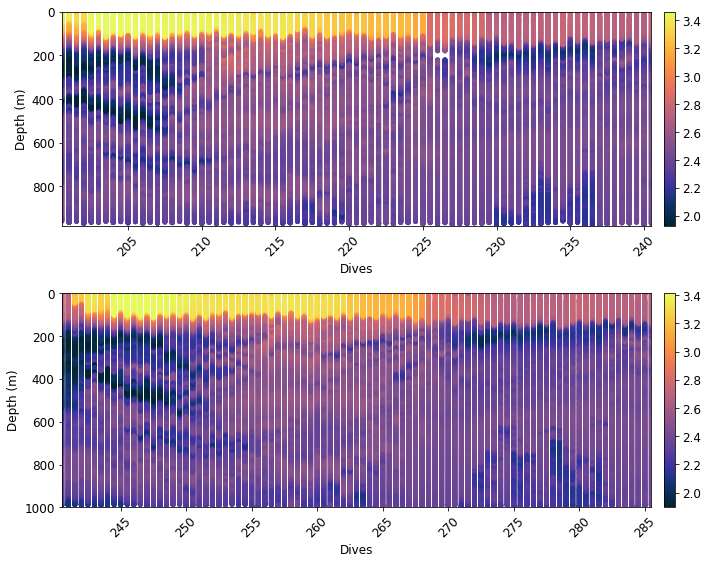

In [74]:
fig= plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

plot_sections_scatter(ds_659,  'dives', 'pressure', 'temperature', 
              section_1_659, cmap=cmo.thermal, size=15, ax=ax1)

plt.subplot(212)
plot_sections_scatter(ds_660,  'dives', 'pressure', 'temperature', 
              section_1_660, cmap=cmo.thermal, size=15, ax=ax2)

There are a large number of points to plot (126676). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


There are a large number of points to plot (122038). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


(1027.8, 1026.8)

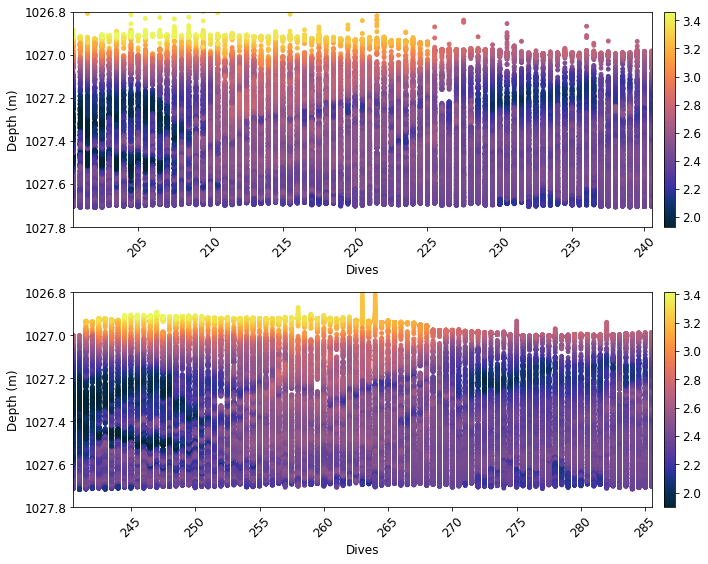

In [88]:
fig= plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

plot_sections_scatter(ds_659,  'dives', 'potdens', 'temperature', 
              section_1_659, cmap=cmo.thermal, size=15, ax=ax1)
ax1.set_ylim([1027.8, 1026.8])

plt.subplot(212)
plot_sections_scatter(ds_660,  'dives', 'potdens', 'temperature', 
              section_1_660, cmap=cmo.thermal, size=15, ax=ax2)
ax2.set_ylim([1027.8, 1026.8])

There are a large number of points to plot (134443). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


There are a large number of points to plot (127009). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


(1027.8, 1026.8)

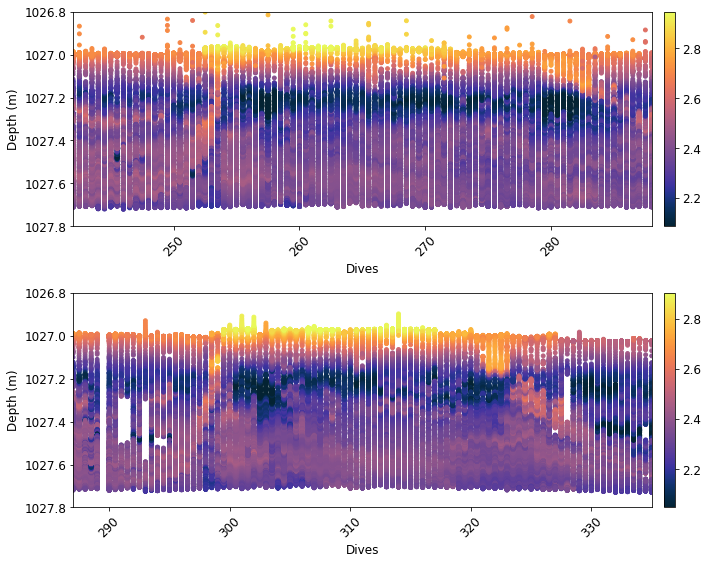

In [89]:
fig= plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

plot_sections_scatter(ds_659,  'dives', 'potdens', 'temperature', 
              section_2_659, cmap=cmo.thermal, size=15, ax=ax1)
ax1.set_ylim([1027.8, 1026.8])

plt.subplot(212)
plot_sections_scatter(ds_660,  'dives', 'potdens', 'temperature', 
              section_2_660, cmap=cmo.thermal, size=15, ax=ax2)
ax2.set_ylim([1027.8, 1026.8])

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


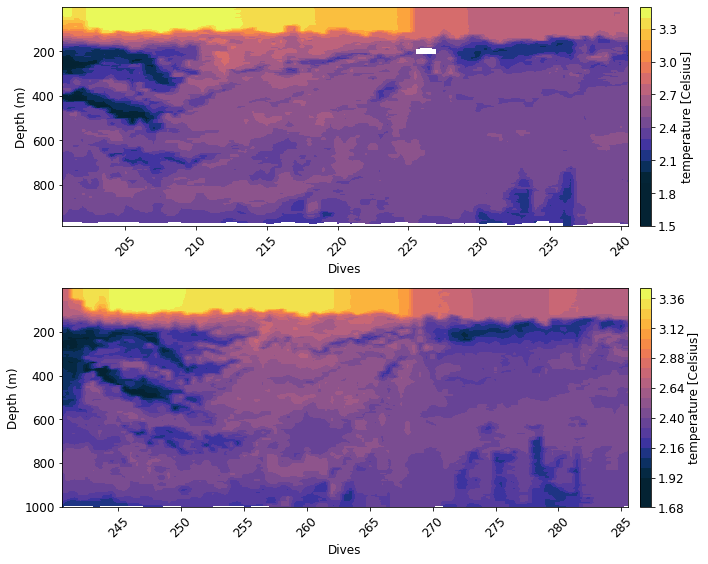

In [84]:
fig= plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

plot_sections_contourf(ds_659,  'dives', 'pressure', 'temperature', 
              section_1_659, cmap=cmo.thermal,ax=ax1)

plt.subplot(212)
plot_sections_contourf(ds_660,  'dives', 'pressure', 'temperature', 
              section_1_660, cmap=cmo.thermal,  ax=ax2)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


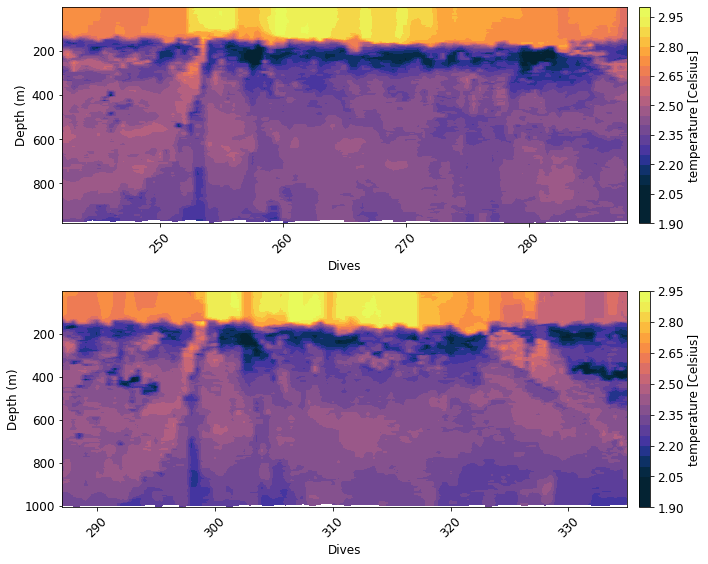

In [90]:
fig= plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

plot_sections_contourf(ds_659,  'dives', 'pressure', 'temperature', 
              section_2_659, cmap=cmo.thermal,ax=ax1)

plt.subplot(212)
plot_sections_contourf(ds_660,  'dives', 'pressure', 'temperature', 
              section_2_660, cmap=cmo.thermal,  ax=ax2)

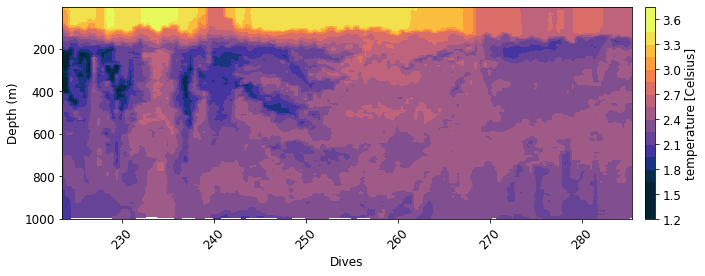

In [85]:
fig= plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,1,1)

plot_sections_contourf(ds_660,  'dives', 'pressure', 'temperature', 
              section_1_660_long, cmap=cmo.thermal, ax=ax1)

There are a large number of points to plot (134444). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


There are a large number of points to plot (133338). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


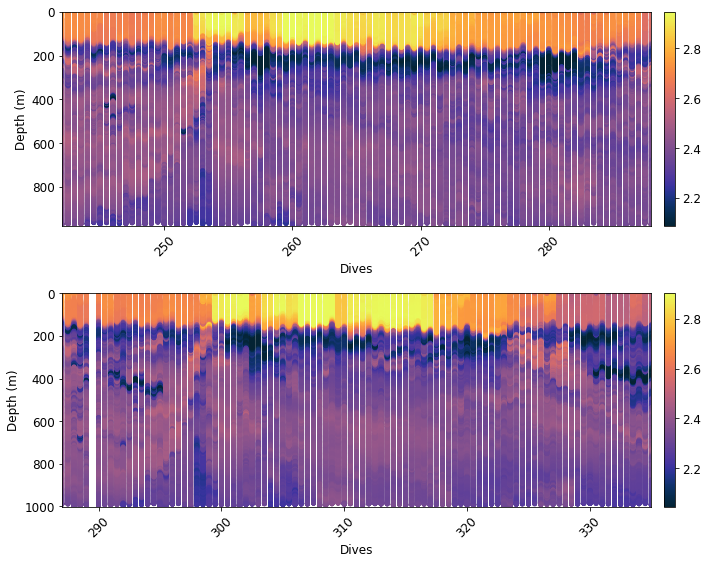

In [65]:
fig= plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

plot_sections(ds_659, 'dives', 'pressure', 'temperature', 
              section_2_659, cmap=cmo.thermal, size=15, ax=ax1)

plt.subplot(212)
plot_sections(ds_660, 'dives', 'pressure', 'temperature', 
              section_2_660, cmap=cmo.thermal, size=15, ax=ax2)

### Convert lat-lon 2 m

In [123]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [124]:
lat_660 = ds_660.latitude.groupby(ds_660.dives).mean()
lon_660 = ds_660.longitude.groupby(ds_660.dives).mean()

lat_659 = ds_659.latitude.groupby(ds_659.dives).mean()
lon_659 = ds_659.longitude.groupby(ds_659.dives).mean()

In [125]:
# convert to distance coordinate

# set coordinates at 30E lon and -54S
ref_x = 30,
ref_y = -54
deg2m = 111139.

In [148]:
def lonlat2xy(ds, ref_x, reg_y):
    deg2m = 111139.
    
    X = great_circle_distance(ds.longitude, ds.latitude, 
                              ref_x, ds.latitude)*deg2m
    Y = great_circle_distance(ds.longitude, ds.latitude, 
                              ds.longitude, ref_y)*deg2m

    return X.rename('X'), Y.rename('Y')

In [149]:
X_659, Y_659 = lonlat2xy(xr.merge([lon_659, lat_659]), ref_x, ref_y)
X_660, Y_660 = lonlat2xy(xr.merge([lon_660, lat_660]), ref_x, ref_y)

In [150]:
source_659 = ColumnDataSource(data=dict(
    x=X_659.values/1e3,
    y=Y_659.values/1e3,
    dives=X_659.dives.values,
))

source_660 = ColumnDataSource(data=dict(
    x=X_660.values/1e3,
    y=Y_660.values/1e3,
    dives=X_660.dives.values,
))

TOOLTIPS = [
    ("dive", "@dives"),
    ("(x,y)", "($x, $y)"),
]

p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS,
           title="Tracks")

# add a circle renderer with x and y coordinates, size, color, and alpha
p.circle('x', 'y', source=source_659)

p.circle('x', 'y', source=source_660, color='black')

show(p)

# section 1 = 200-241
# section 2 = 241.5 - 288.5

## Interpolate linearly in the horizontal and grid in vertical

In [106]:
sec = section_1_659
selection = np.logical_and(ds_659.dives<=sec[1], ds_659.dives>=sec[0])
ds_659_sel = ds_659.where(selection, drop=True)

In [151]:
X_659_sel, Y_659_sel = lonlat2xy(ds_659_sel, ref_x, ref_y)

In [152]:
ds_659_sel = xr.merge([ds_659_sel, X_659_sel, Y_659_sel])

In [214]:
latitude_grided = gt.grid_data(dss.dives, dss.pressure, 
                               dss.latitude, bins=np.linspace(0,1000,1001))
longitude_grided = gt.grid_data(dss.dives, dss.pressure, 
                               dss.longitude, bins=np.linspace(0,1000,1001))

Mean bin size = 1.00
Mean depth binned (50 m) vertical sampling frequency = 0.62
Mean bin size = 1.00
Mean depth binned (50 m) vertical sampling frequency = 0.62


In [ ]:
# interpolate to constant vertical grid 
dss = ds_659_sel

temp_grided = gt.grid_data(dss.dives, dss.pressure, 
                               dss.temperature, bins=np.linspace(0,1000,1001))
Y_grided = gt.grid_data(dss.dives, dss.pressure, 
                               dss.Y, bins=np.linspace(0,1000,1001))
X_grided = gt.grid_data(dss.dives, dss.pressure, 
                               dss.X, bins=np.linspace(0,1000,1001))
dens_grided = gt.grid_data(dss.dives, dss.pressure, 
                               dss.potdens, bins=np.linspace(0,1000,1001))
# does binning in the vertical

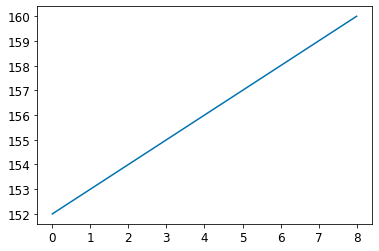

In [210]:
plt.plot(np.unique(dss.round_days))

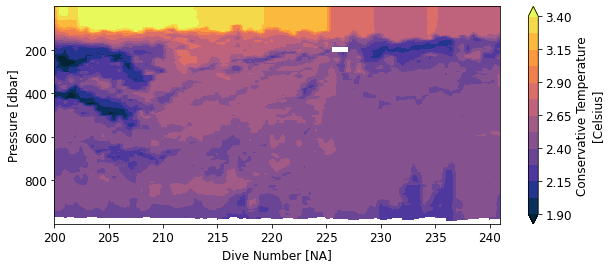

In [391]:
plt.figure(figsize=(10,4))
temp_grided.plot.contourf(levels=np.linspace(1.9,3.4,13), 
                          cmap=cmo.thermal)
plt.gca().invert_yaxis()

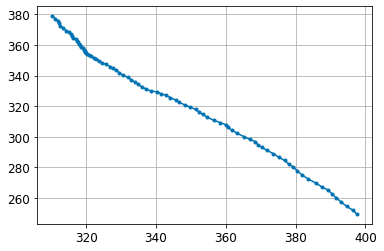

In [162]:
# what does track look like 
plt.plot(X_grided.mean('pressure')/1e3, 
         Y_grided.mean('pressure')/1e3, marker='.')
plt.grid()

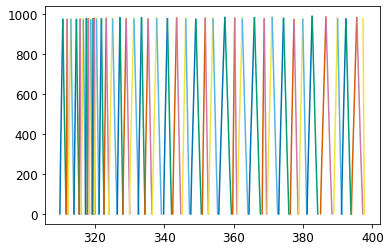

In [158]:
plt.plot(X_grided/1e3, X_grided.pressure);

In [186]:
# since the track is "straightish", we fit a line through it first m
X_data = X_grided.mean('pressure').values.reshape(-1)
Y_data = Y_grided.mean('pressure').values.reshape(-1)
linreg_np = np.polyfit(X_data, Y_data, deg=1)

In [188]:
linreg_scipy = linregress(X_data, Y_data)

In [190]:
linreg_np

array([-1.34105832e+00,  7.87267952e+05])

In [189]:
linreg_scipy

LinregressResult(slope=-1.3410583152925155, intercept=787267.9519436657, rvalue=-0.9964396892051318, pvalue=8.780211968438168e-89, stderr=0.012607419080789713)

In [195]:
Y_fit = linreg_np[0]*X_data + linreg_np[1]

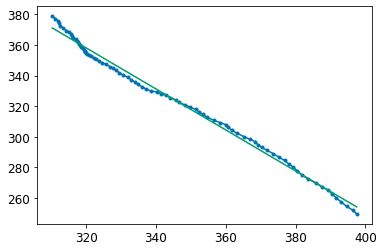

In [196]:
plt.plot(X_data/1e3, Y_data/1e3, marker='.')
plt.plot(X_data/1e3, Y_fit/1e3)

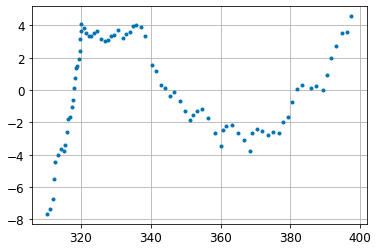

In [178]:
plt.plot(X_data/1e3, (Y_fit-Y_data)/1e3, '.')
plt.grid()

In [187]:
from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
import numpy as np


def orthoregress(x, y):
    """Perform an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.
    Arguments:
    x: x data
    y: y data
    Returns:
    [m, c, nan, nan, nan]
    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.
    """
    linreg = linregress(x, y)
    mod = Model(f)
    dat = Data(x, y)
    od = ODR(dat, mod, beta0=linreg[0:2])
    out = od.run()

    return list(out.beta) + [np.nan, np.nan, np.nan]


def f(p, x):
    """Basic linear regression 'model' for use with ODR"""
    return (p[0] * x) + p[1]

In [191]:
ODR_regress = orthoregress(X_data, Y_data)

In [192]:
ODR_regress

[-1.3472381824397694, 789398.9698774553, nan, nan, nan]

In [194]:
linreg_np

array([-1.34105832e+00,  7.87267952e+05])

In [197]:
Y_fit_odr = ODR_regress[0]*X_data + ODR_regress[1]

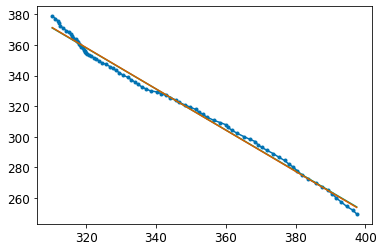

In [198]:
plt.plot(X_data/1e3, Y_data/1e3, marker='.')
plt.plot(X_data/1e3, Y_fit/1e3)
plt.plot(X_data/1e3, Y_fit_odr/1e3)

In [201]:
# estimate the perpendicular distance from the line 
def perp_distance(line_params, xo, yo):
    
    dist = np.abs(yo - line_params[0]*xo - line_params[1])/np.sqrt(line_params[0]**2+1)
    
    return dist

In [221]:
# estimate the perpendicular distance from the line 
def perp_projection(line_params, xo, yo):
    a = -line_params[0]
    b = 1 
    c = -line_params[1]
    
    x_n = (b*(b*xo - a*yo) - a*c)/(a**2 + b**2)
    y_n = (a*(-b*xo + a*yo) - b*c)/(a**2 + b**2)
    
    return x_n, y_n

In [203]:
perp_dist_ODR = perp_distance(ODR_regress, X_data, Y_data)
perp_dist_LR = perp_distance(linreg_np, X_data, Y_data)

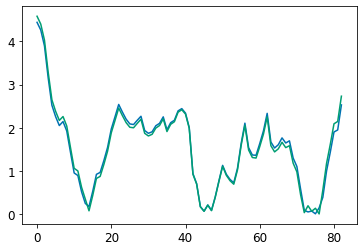

In [205]:
plt.plot(perp_dist_ODR/1e3)
plt.plot(perp_dist_LR/1e3)

Text(0.5, 0, 'km')

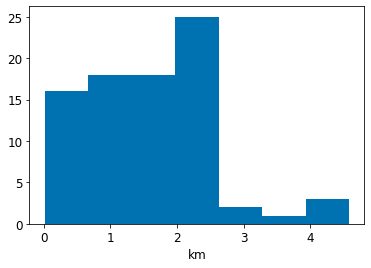

In [213]:
plt.hist(perp_dist_LR/1e3, 7);
plt.xlabel('km')

The distance between regular linear regress and ODR is not that much. 
This also suggests that with gliders it is probably not possible to explore scales smaller than about 5kms, since gliders don't travel very straight. This is particularly true when trying to go to these traditional statistics. 

In [230]:
X_n, Y_n = perp_projection(ODR_regress, X_grided, Y_grided)

In [231]:
def distances(X,Y, X_o, Y_o): 
    
    dist = np.sqrt((X - X_o)**2 + (Y - Y_o)**2)
    
    return dist

In [240]:
dist_gridded = distances(X_n, Y_n, X_n[0,0], Y_n[0,0])

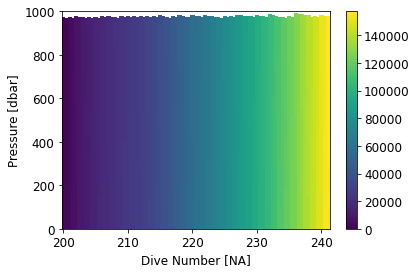

In [241]:
dist_gridded.plot()

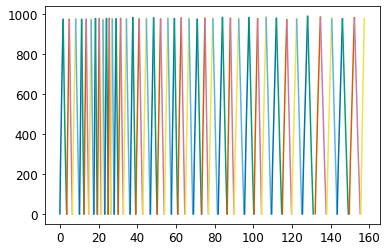

In [245]:
plt.plot(dist_gridded/1e3, dist_gridded.pressure);

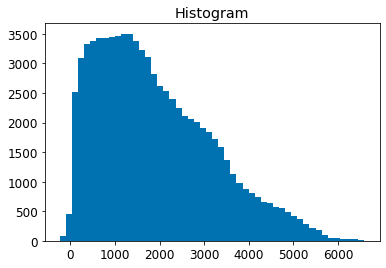

In [248]:
dist_gridded.diff('dives').plot.hist(bins=50);

In [250]:
dx = 500
dist_reg = np.arange(dist_gridded.min(),dist_gridded.max(), dx) 

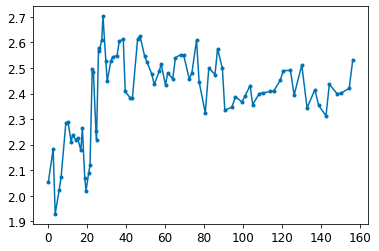

In [257]:
plt.plot(dist_gridded.sel(pressure=300, method='nearest')/1e3,
         temp_grided.sel(pressure=300, method='nearest'),marker='.')

In [266]:
temp_grided

<xarray.DataArray 'temperature_vert_binned' (pressure: 1000, dives: 83)>
array([[3.07313003, 3.42744493, 3.43205915, ..., 2.71171117, 2.75207634,
        2.74754573],
       [3.07313003, 3.42910091, 3.43205915, ..., 2.71171117, 2.74702158,
        2.74754573],
       [3.07313003, 3.42921875, 3.43205915, ..., 2.71171117, 2.74436697,
        2.74754573],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * pressure  (pressure) float64 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
  * dives     (dives) float64 200.0 200.5 201.0 201.5 ... 240.0 240.5 241.0
Attributes:
    units:          Celsius
    standard_name:  Conservative Temperature
    history:        [2020-10-06 14:01:54] (vversion_undefined) glidertools.ma...

In [259]:
from  scipy.interpolate import interp1d

In [278]:
def interp_on_dist(var):
    var_interp = np.zeros((len(var.pressure), len(dist_reg)))

    for i in range(0, len(var.pressure)) :
        func = interp1d(dist_gridded.isel(pressure=i),
                   var.isel(pressure=i),
                   fill_value=np.NaN, bounds_error=False)

        var_interp[i,:] = func(dist_reg)

    var_interp = xr.DataArray(var_interp, dims=["pressure", "dist"],
                          coords={"pressure":var.pressure,
                                             "dist":dist_reg})
    
    return var_interp

In [280]:
temp_interp = interp_on_dist(temp_grided)
dens_interp = interp_on_dist(dens_grided)

In [356]:
temp_interp

<xarray.DataArray (pressure: 1000, dist: 315)>
array([[3.07313003, 3.12376732, 3.17440462, ...,        nan,        nan,
               nan],
       [3.07313003, 3.12413404, 3.17513806, ...,        nan,        nan,
               nan],
       [3.07313003, 3.12418932, 3.1752486 , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * pressure  (pressure) float64 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
  * dist      (dist) float64 0.0 500.0 1e+03 ... 1.56e+05 1.565e+05 1.57e+05

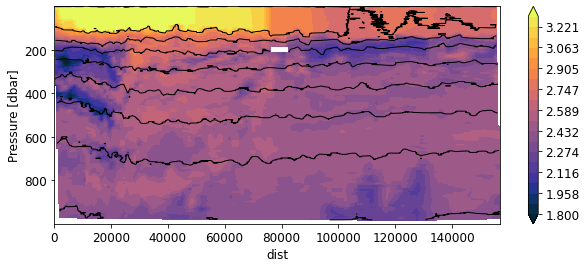

In [292]:
plt.figure(figsize=(10,4))
temp_interp.plot.contourf(levels=np.linspace(1.8,3.3,20), cmap=cmo.thermal)
dens_interp.plot.contour(levels=np.linspace(1026.8, 1027.8,11), 
                         colors='k', linewidths=1.)

plt.gca().invert_yaxis()

### Use scipy's interp functions
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata

In [293]:
from scipy.interpolate import griddata

In [303]:
pres_ug = ds_659_sel.pressure

In [333]:
X_n_ug, Y_n_ug = perp_projection(ODR_regress,
                                 X_659_sel, Y_659_sel)
dist_ug = distances(X_n_ug, Y_n_ug, X_n_ug[0], Y_n_ug[0])

In [368]:
dist_ug

<xarray.DataArray (ctd_data_point: 131032)>
array([0.00000000e+00, 7.10815012e-01, 1.76055325e+00, ...,
       1.57378037e+05, 1.57379255e+05, 1.57380473e+05])
Dimensions without coordinates: ctd_data_point

In [334]:
points = np.stack([dist_ug.values, pres_ug.values],
                       axis=1)

In [337]:
values = ds_659_sel.temperature.values

In [338]:
print(points.shape, values.shape)

(131032, 2) (131032,)


In [344]:
non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))

In [345]:
non_nan.shape

(131032,)

In [346]:
points =points[non_nan,:]

In [349]:
values =values[non_nan]

In [350]:
print(points.shape, values.shape)

(129745, 2) (129745,)


In [378]:
pres_grid = temp_interp.pressure#np.linspace(0,1000,1001)
dist_grid = dist_reg

In [379]:
grid_p, grid_d = np.meshgrid(pres_grid, dist_grid)

In [380]:
temp_grided_2 = griddata(points, values, 
                         (grid_d, grid_p), 
                         method='linear', rescale=True)

In [381]:
temp_grided_2.shape

(315, 1000)

In [382]:
temp_grided_2 = xr.DataArray(temp_grided_2.T, dims=["pressure", "dist"],
                          coords={"pressure":pres_grid,
                                             "dist":dist_grid})

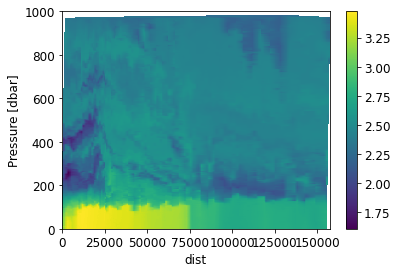

In [383]:
temp_grided_2.plot()

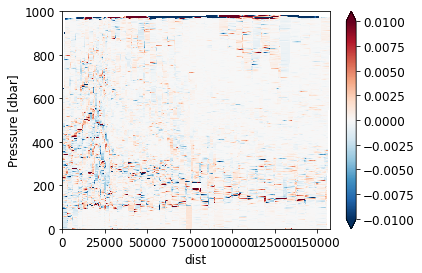

In [385]:
(temp_grided_2 - temp_interp).plot(vmin=-0.01)

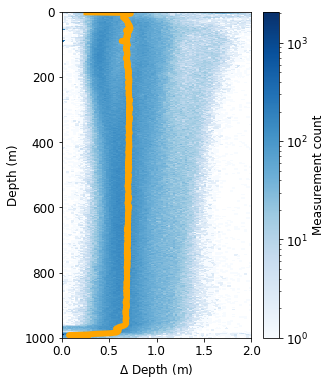

In [6]:
ax = gt.plot.bin_size(ds_660.pressure , 
                      bins=[np.linspace(0,10,401),np.linspace(0,1000,500)], cmap='Blues')
ax.set_xlim(0, 2)
line = ax.get_children()[1]
line.set_linewidth(6)
line.set_color('orange')

legend = ax.get_children()[-2]
legend.set_visible(False)

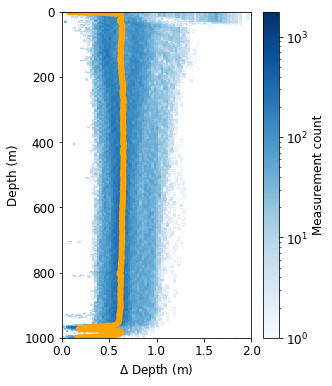

In [7]:
ax = gt.plot.bin_size(ds_659.pressure , 
                      bins=[np.linspace(0,10,401),np.linspace(0,1000,500)], cmap='Blues')
ax.set_xlim(0, 2)
line = ax.get_children()[1]
line.set_linewidth(6)
line.set_color('orange')

legend = ax.get_children()[-2]
legend.set_visible(False)

In [ ]:
ds_659['potdens'] = gt.physics.potential_density(ds_659.salinity, ds_659.temperature, 
                                   ds_659.pressure, ds_659.latitude, 
                                   ds_659.longitude)

In [83]:
ds_660['potdens'] = gt.physics.potential_density(ds_660.salinity, ds_660.temperature, 
                                   ds_660.pressure, ds_660.latitude, 
                                   ds_660.longitude)

In [76]:
temp_grided_659 = gt.grid_data(ds_659.dives, ds_659.pressure, ds_659.temperature)
salt_grided_659 = gt.grid_data(ds_659.dives, ds_659.pressure, ds_659.salinity)
dens_grided_659 = gt.grid_data(ds_659.dives, ds_659.pressure, ds_659.potdens)

Mean bin size = 0.95
Mean depth binned (50 m) vertical sampling frequency = 0.63
Mean bin size = 0.95
Mean depth binned (50 m) vertical sampling frequency = 0.63
Mean bin size = 0.95
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [84]:
temp_grided_660 = gt.grid_data(ds_660.dives, ds_660.pressure, ds_660.temperature)
salt_grided_660 = gt.grid_data(ds_660.dives, ds_660.pressure, ds_660.salinity)
dens_grided_660 = gt.grid_data(ds_660.dives, ds_660.pressure, ds_660.potdens)

Mean bin size = 0.95
Mean depth binned (50 m) vertical sampling frequency = 0.69
Mean bin size = 0.95
Mean depth binned (50 m) vertical sampling frequency = 0.69
Mean bin size = 0.95
Mean depth binned (50 m) vertical sampling frequency = 0.69


Things work qualitatively well when working with the full data set using GT's inbuilt plotting function. 
I am not sure if I trust it completely, so will re-evaluate. 

There are a large number of points to plot (297635). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(0.5, 1.0, 'Temp Data 659')

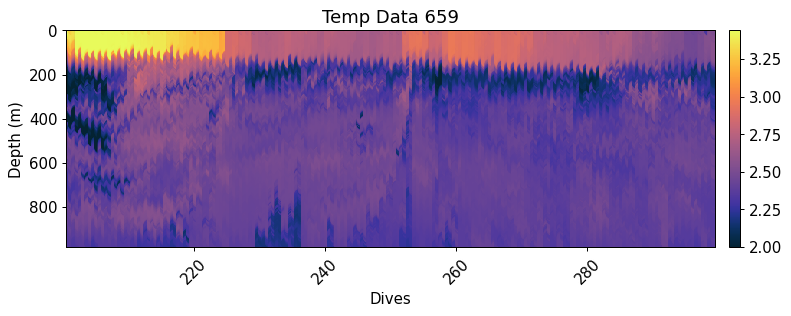

In [18]:
gt.plot.scatter(ds_659.dives.where(np.logical_and(ds_659.dives<300, ds_659.dives>200), drop=True),
        ds_659.pressure.where(np.logical_and(ds_659.dives<300, ds_659.dives>200), drop=True),
        ds_659.temperature.where(np.logical_and(ds_659.dives<300, ds_659.dives>200), drop=True),
        cmap=cmo.thermal, robust=True)
plt.title('Temp Data 659')

There are a large number of points to plot (331294). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(0.5, 1.0, 'Temp Data 659')

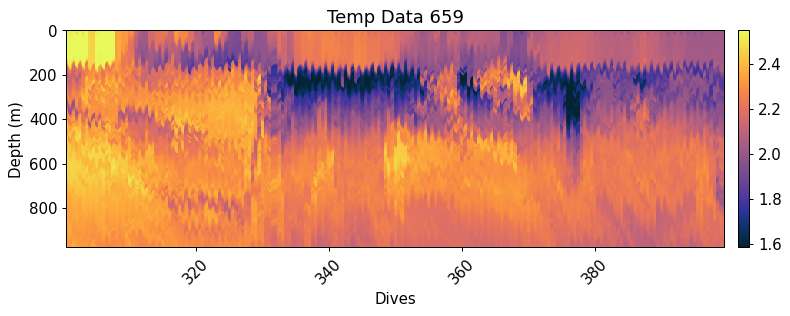

In [55]:
gt.plot.scatter(ds_659.dives.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        ds_659.pressure.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        ds_659.temperature.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        cmap=cmo.thermal, robust=True)
plt.title('Temp Data 659')

There are a large number of points to plot (331381). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(0.5, 1.0, 'Salt Data 659')

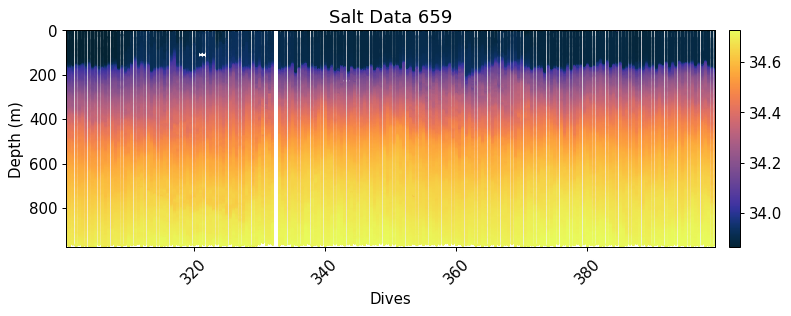

In [123]:
gt.plot.scatter(ds_659.dives.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        ds_659.pressure.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        ds_659.salinity.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        cmap=cmo.thermal, robust=True, s=.8)
plt.title('Salt Data 659')

There are a large number of points to plot (331381). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(0.5, 1.0, 'Salt Data 659')

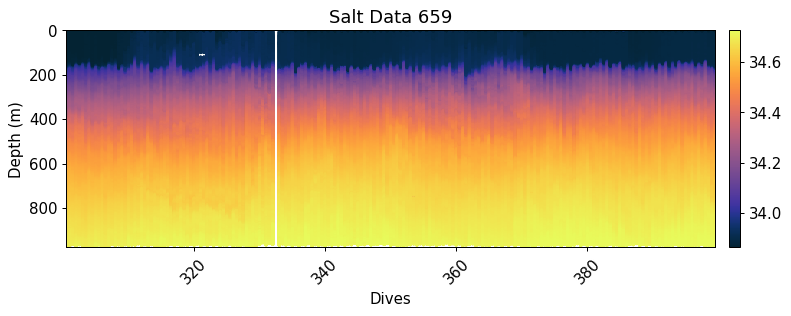

In [122]:
gt.plot.scatter(ds_659.dives.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        ds_659.pressure.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        ds_659.salinity.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        cmap=cmo.thermal, robust=True, s=2.5)
plt.title('Salt Data 659')

There are a large number of points to plot (331224). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(0.5, 1.0, 'Dens Data 659')

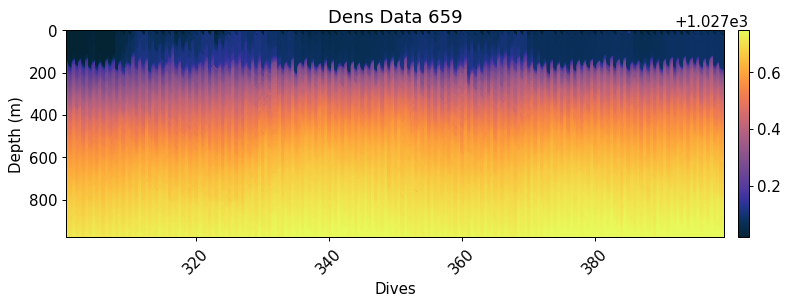

In [75]:
gt.plot.scatter(ds_659.dives.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        ds_659.pressure.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        ds_659.potdens.where(np.logical_and(ds_659.dives<400, ds_659.dives>300), drop=True),
        cmap=cmo.thermal, robust=True)
plt.title('Dens Data 659')

There are a large number of points to plot (275710). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(0.5, 1.0, 'Temp Data 660')

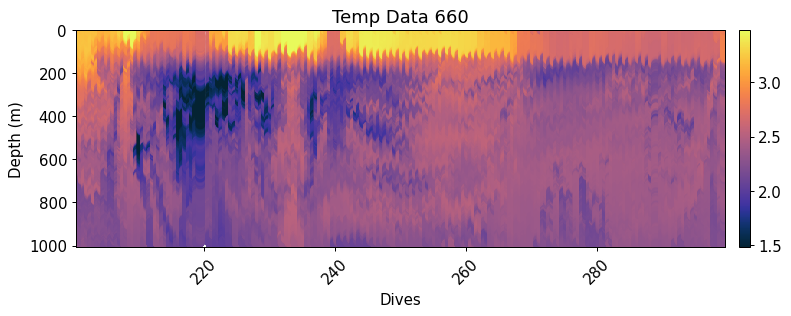

In [57]:
gt.plot.scatter(ds_660.dives.where(np.logical_and(ds_660.dives<300, ds_660.dives>200), drop=True),
        ds_660.pressure.where(np.logical_and(ds_660.dives<300, ds_660.dives>200), drop=True),
        ds_660.temperature.where(np.logical_and(ds_660.dives<300, ds_660.dives>200), drop=True),
        cmap=cmo.thermal, robust=True)
plt.title('Temp Data 660')

There are a large number of points to plot (292675). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(0.5, 1.0, 'Temp Data 660')

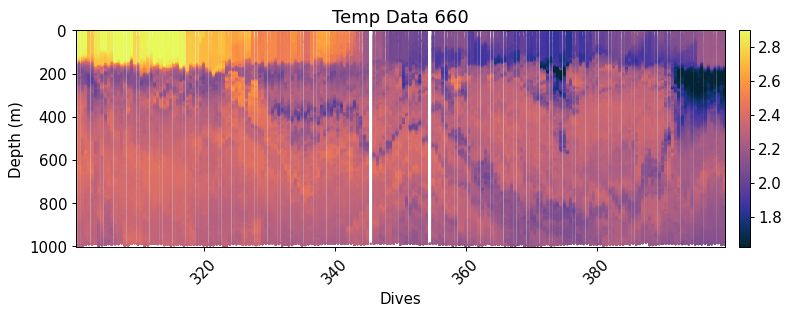

In [119]:
gt.plot.scatter(ds_660.dives.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        ds_660.pressure.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        ds_660.temperature.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        cmap=cmo.thermal, robust=True, s=1)
plt.title('Temp Data 660')

There are a large number of points to plot (292675). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(0.5, 1.0, 'Temp Data 660')

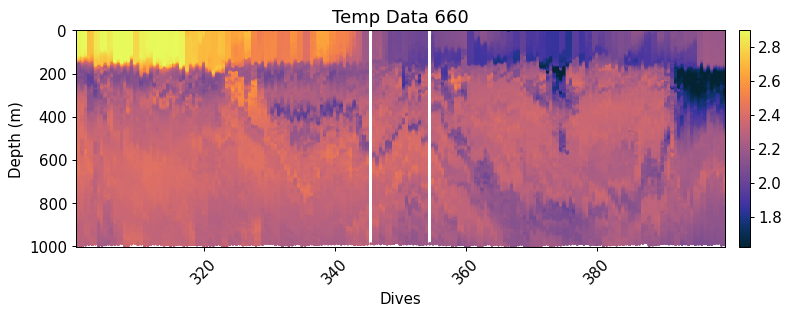

In [120]:
gt.plot.scatter(ds_660.dives.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        ds_660.pressure.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        ds_660.temperature.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        cmap=cmo.thermal, robust=True, s=2)
plt.title('Temp Data 660')

There are a large number of points to plot (278484). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(63.75, 0.5, 'Density')

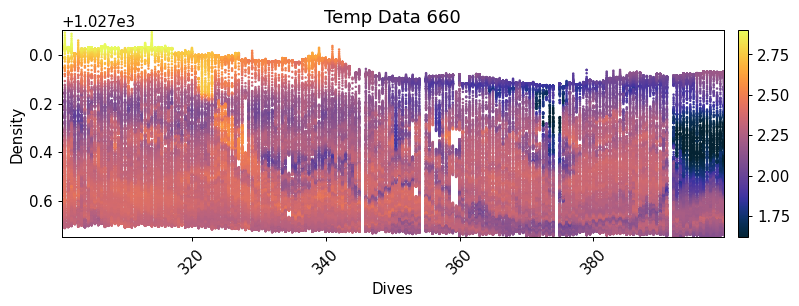

In [124]:
gt.plot.scatter(ds_660.dives.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        ds_660.potdens.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        ds_660.temperature.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        cmap=cmo.thermal, robust=True, s=1)
plt.title('Temp Data 660')
plt.ylabel('Density')

There are a large number of points to plot (278484). This will take a while to plot.
Type "y" to continue or "n" to cancel.
 y


Text(63.75, 0.5, 'Density')

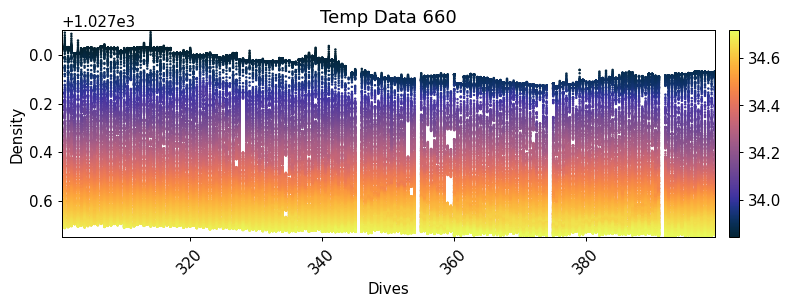

In [125]:
gt.plot.scatter(ds_660.dives.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        ds_660.potdens.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        ds_660.salinity.where(np.logical_and(ds_660.dives<400, ds_660.dives>300), drop=True),
        cmap=cmo.thermal, robust=True, s=1)
plt.title('Temp Data 660')
plt.ylabel('Density')

In [19]:
profile1 = ds_659.where(ds_659.dives==300, drop=True)
profile2 = ds_659.where(ds_659.dives==300.5, drop=True)

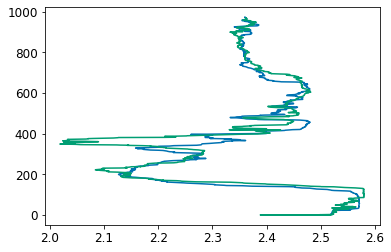

In [21]:
plt.plot( profile1.temperature , profile1.pressure)
plt.plot( profile2.temperature , profile2.pressure)

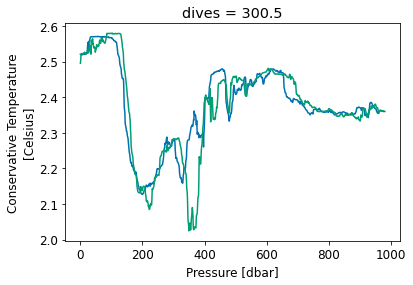

In [24]:
temp_grided_659.sel(dives=300).plot()
temp_grided_659.sel(dives=300.5).plot()

In [28]:
n = np.arange(np.min(np.floor(temp_grided_659.dives)),
                np.max(np.floor(temp_grided_659.dives)))

In [34]:
len(temp_grided_659.pressure)
len(n)

461

In [85]:
tdiff_659 = np.nan*np.ones((len(temp_grided_659.pressure), len(n)))
sdiff_659 = np.nan*np.ones((len(temp_grided_659.pressure), len(n)))
rhodiff_659 = np.nan*np.ones((len(temp_grided_659.pressure), len(n)))
for i in n: 
    try: 
        tdiff_659[:,int(i)] =  (temp_grided_659.sel(dives=i) -  temp_grided_659.sel(dives=i+0.5)).values
        sdiff_659[:,int(i)] =  (salt_grided_659.sel(dives=i) -  salt_grided_659.sel(dives=i+0.5)).values
        rhodiff_659[:,int(i)] =  (dens_grided_659.sel(dives=i) -  dens_grided_659.sel(dives=i+0.5)).values
    except:
        print("missing"+str(i))

missing96.0
missing461.0


In [86]:
tdiff_660 = np.nan*np.ones((len(temp_grided_660.pressure), len(n)))
sdiff_660 = np.nan*np.ones((len(temp_grided_660.pressure), len(n)))
rhodiff_660 = np.nan*np.ones((len(temp_grided_660.pressure), len(n)))
for i in n: 
    try: 
        tdiff_660[:,int(i)] =  (temp_grided_660.sel(dives=i) -  temp_grided_660.sel(dives=i+0.5)).values
        sdiff_660[:,int(i)] =  (salt_grided_660.sel(dives=i) -  salt_grided_660.sel(dives=i+0.5)).values
        rhodiff_660[:,int(i)] =  (dens_grided_660.sel(dives=i) -  dens_grided_660.sel(dives=i+0.5)).values
    except:
        print("missing"+str(i))

missing6.0
missing15.0
missing32.0
missing220.0
missing289.0
missing400.0
missing461.0


In [60]:
from scipy import stats

Text(0.5, 0.98, '659')

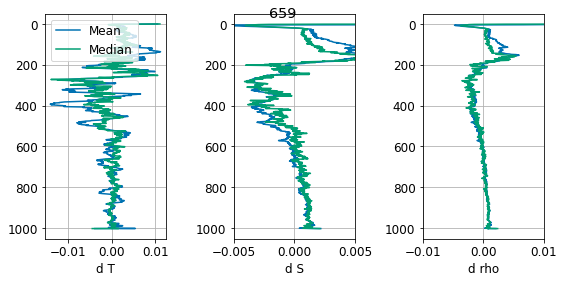

In [104]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.plot(np.nanmean(tdiff_659,axis=1),temp_grided_659.pressure, label='Mean')
plt.plot(np.nanmedian(tdiff_659,axis=1),temp_grided_659.pressure, label='Median')
plt.grid()
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('d T')

plt.subplot(132)
plt.plot(np.nanmean(sdiff_659,axis=1),temp_grided_659.pressure, label='Mean')
plt.plot(np.nanmedian(sdiff_659,axis=1),temp_grided_659.pressure, label='Median')
plt.grid()
plt.xlim([-0.005,0.005])
plt.gca().invert_yaxis()
plt.xlabel('d S')

plt.subplot(133)
plt.plot(np.nanmean(rhodiff_659,axis=1),temp_grided_659.pressure, label='Mean')
plt.plot(np.nanmedian(rhodiff_659,axis=1),temp_grided_659.pressure, label='Median')
plt.grid()
plt.xlim([-0.01,0.01])
plt.gca().invert_yaxis()
plt.xlabel('d rho')
plt.tight_layout()

plt.suptitle('659')

Text(0.5, 0.98, '660')

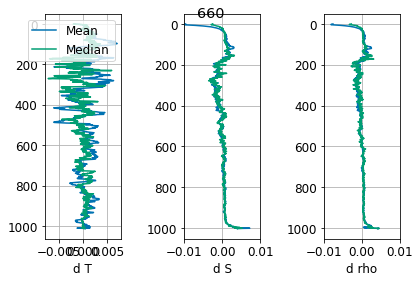

In [97]:
plt.subplot(131)
plt.plot(np.nanmean(tdiff_660,axis=1),temp_grided_660.pressure, label='Mean')
plt.plot(np.nanmedian(tdiff_660,axis=1),temp_grided_660.pressure, label='Median')
plt.grid()
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('d T')

plt.subplot(132)
plt.plot(np.nanmean(sdiff_660,axis=1),temp_grided_660.pressure, label='Mean')
plt.plot(np.nanmedian(sdiff_660,axis=1),temp_grided_660.pressure, label='Median')
plt.grid()
plt.xlim([-0.01,0.01])
plt.gca().invert_yaxis()
plt.xlabel('d S')

plt.subplot(133)
plt.plot(np.nanmean(rhodiff_660,axis=1),temp_grided_660.pressure, label='Mean')
plt.plot(np.nanmedian(rhodiff_660,axis=1),temp_grided_660.pressure, label='Median')
plt.grid()
plt.xlim([-0.01,0.01])
plt.gca().invert_yaxis()
plt.xlabel('d rho')
plt.tight_layout()
plt.suptitle('660')

In [101]:
0.004/0.7*100


0.5714285714285715

(-0.02, 0.02)

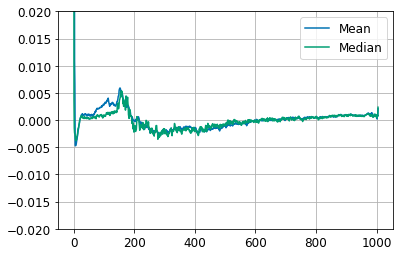

In [81]:
plt.plot(np.nanmean(rhodiff,axis=1), label='Mean')
plt.plot(np.nanmedian(rhodiff,axis=1), label='Median')
plt.grid()
plt.legend()
plt.ylim([-0.02,0.02])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.99175792, -0.76749911, -0.5432403 , -0.31898149, -0.09472269,
         0.12953612,  0.35379493,  0.57805373,  0.80231254,  1.02657135,
         1.25083015]),
 <a list of 461 BarContainer objects>)

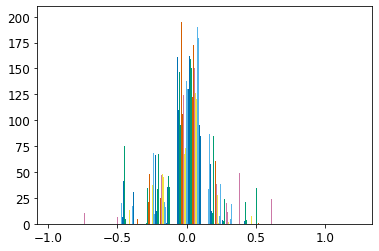

In [54]:
plt.hist(tdiff[100:300,:])

In [39]:
(temp_grided_659.sel(dives=i) -  temp_grided_659.sel(dives=i+0.5)).values.shape

(1099,)

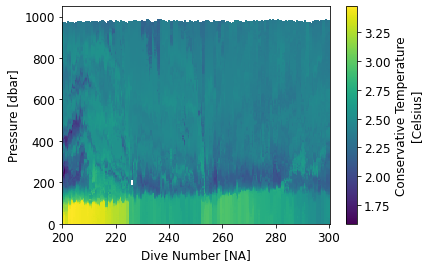

In [26]:
temp_grided_659.sel(dives=slice(200,300)).plot()

In [12]:
profile = ds_659.where(ds_659.dives==300, drop=True)

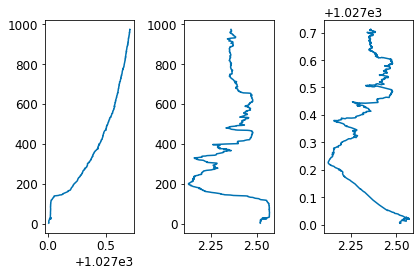

In [14]:
plt.subplot(131)
plt.plot(profile.potdens, profile.pressure )

plt.subplot(132)
plt.plot( profile.temperature, profile.pressure)

plt.subplot(133)
plt.plot(profile.temperature, profile.potdens)

plt.tight_layout()

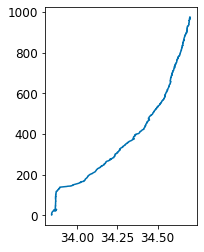

In [105]:
plt.subplot(121)
plt.plot( profile.salinity, profile.pressure )


In [115]:
(profile.salinity.min()- profile.salinity.max())

<xarray.DataArray 'salinity' ()>
array(-0.8562853)

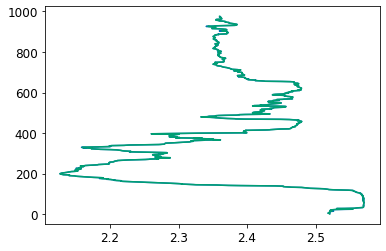

In [19]:
plt.subplot(121)
plt.plot( profile.temperature, profile.pressure )
plt.plot( temp_grid, temp_grid.pressure )



In [17]:
temp_depth = gt.grid_data(profile.dives, profile.pressure, profile.temperature)

Mean bin size = 1.06
Mean depth binned (50 m) vertical sampling frequency = 0.89


In [35]:
temp_dens = gt.grid_data(profile.dives, dens, profile.temperature, 
                         bins = np.linspace(dens.min().values, dens.max().values,101))

Mean bin size = 0.01
Mean depth binned (50 m) vertical sampling frequency = 0.00


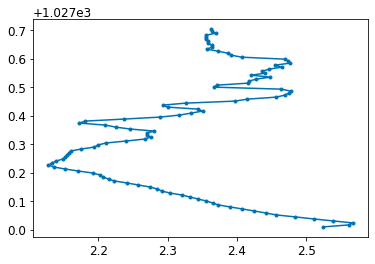

In [37]:
plt.plot(temp_dens, temp_dens.potential_density, '.-')

In [ ]:
 = gt.grid_data(ds_659.dives, dens, profile.temperature, 
                         bins = np.linspace(dens.min().values, dens.max().values,201))